In [1]:
# Import all stuff we need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pylab
from brian import Network, Equations, NeuronGroup, Connection,\
    SpikeMonitor, raster_plot, StateMonitor, clear, reinit
from brian.stdunits import ms, mV
from sklearn.cross_validation import KFold


%matplotlib inline
pylab.rcParams['figure.figsize'] = 12, 8  # changes figure size (width, height) for larger images

/Users/Jan/.virtualenvs/research/lib/python2.7/site-packages/brian/utils/sparse_patch/__init__.py:39: UserWarning: Couldn't find matching sparse matrix patch for scipy version 0.15.1, but in most cases this shouldn't be a problem.
  warnings.warn("Couldn't find matching sparse matrix patch for scipy version %s, but in most cases this shouldn't be a problem." % scipy.__version__)


In [2]:
clear(True, True) 
reinit()# To reinit BRIAN clocks and remove all old BRIAN objects from namespace,
# it's usually a good idea to put this at the beginning of a script

In [3]:
# The equations defining our neuron model
eqs_string = ''' 
            dV/dt = (mu - V)/tau + x: volt
            dx/dt = -1.0/tau_2*(x - y/tau_1) : volt/second
            dy/dt = -y/tau_1 : volt
            mu : volt
            tau: second
            tau_2: second
            tau_1: second
            '''


def get_cluster_connection_probs(REE, k, pee):
    p_out = pee * k/(REE + k -1)
    p_in = REE * p_out
    return p_in, p_out

In [4]:
# simulation parameters 
realizations=1
trials=1 
t=3000 * ms
alpha=1
ree=1
k=50

# Model parameters
n_e = int(4000 * alpha)  # number of exc neurons
n_i = int(1000 * alpha)  # number of inh neurons
tau_e = 15 * ms  # membrane time constant (for excitatory synapses)
tau_i = 10 * ms  # membrane time constant (for inhibitory synapses)
tau_syn_2_e = 3 * ms  # exc synaptic time constant tau2 in paper
tau_syn_2_i = 2 * ms  # inh synaptic time constant tau2 in paper
tau_syn_1 = 1 * ms  # exc/inh synaptic time constant tau1 in paper
vt = -50 * mV  # firing threshold
vr = -65 * mV  # reset potential
refrac = 5 * ms  # absolute refractory period

# scale the weights to ensure same variance in the inputs
wee = 0.024 * 15 * mV * np.sqrt(1. / alpha)
wei = 0.014 * 15 * mV * np.sqrt(1. / alpha)
wii = -0.057 * 15 * mV * np.sqrt(1. / alpha)
wie = -0.045 * 15 * mV * np.sqrt(1. / alpha)

# Connection probability
p_ee = 0.2
p_ii = 0.5
p_ei = 0.5
p_ie = 0.5
# determine probs for inside and outside of clusters
p_in, p_out = get_cluster_connection_probs(ree, k, p_ee)

# increase cluster weights if there are clusters
wee_cluster = wee if p_in == p_out else 1.9 * wee

In [5]:
# set up new random bias parameter for every type of neuron
mu_e = vr + np.random.uniform(1.1, 1.2, n_e) * (vt - vr)  # bias for excitatory neurons
mu_i = vr + np.random.uniform(1.0, 1.05, n_i) * (vt - vr)  # bias for excitatory neurons

# Let's create an equation object from our string and parameters
model_eqs = Equations(eqs_string)

# Let's create 5000 neurons
all_neurons = NeuronGroup(N=n_e + n_i,
                          model=model_eqs,
                          threshold=vt,
                          reset=vr,
                          refractory=refrac,
                          freeze=True,
                          method='Euler',
                          compile=True)

# Divide the neurons into excitatory and inhibitory ones
neurons_e = all_neurons[0:n_e]
neurons_i = all_neurons[n_e:n_e + n_i]

# set the bias
neurons_e.mu = mu_e
neurons_i.mu = mu_i
neurons_e.tau = tau_e
neurons_i.tau = tau_i
neurons_e.tau_2 = tau_syn_2_e
neurons_i.tau_2 = tau_syn_2_i
all_neurons.tau_1 = tau_syn_1

# set up connections
connections = Connection(all_neurons, all_neurons, 'y')

# do the cluster connection like cross validation: cluster neuron := test idx; other neurons := train idx
kf = KFold(n=n_e, n_folds=k)
for idx_out, idx_in in kf:  # idx_out holds all other neurons; idx_in holds all cluster neurons
    # connect current cluster to itself
    connections.connect_random(all_neurons[idx_in[0]:idx_in[-1]], all_neurons[idx_in[0]:idx_in[-1]], 'y',
                               sparseness=p_in, weight=wee_cluster)
    # connect current cluster to other neurons
    connections.connect_random(all_neurons[idx_in[0]:idx_in[-1]], all_neurons[idx_out[0]:idx_out[-1]], 'y',
                               sparseness=p_out, weight=wee)

# connect all excitatory to all inhibitory, irrespective of clustering
connections.connect_random(all_neurons[0:n_e], all_neurons[n_e:(n_e + n_i)], 'y', sparseness=p_ei, weight=wei)
# connect all inhibitory to all excitatory
connections.connect_random(all_neurons[n_e:(n_e + n_i)], all_neurons[0:n_e], 'y', sparseness=p_ie, weight=wie)
# connect all inhibitory to all inhibitory
connections.connect_random(all_neurons[n_e:(n_e + n_i)], all_neurons[n_e:(n_e + n_i)], 'y', sparseness=p_ii,
                           weight=wii)

In [6]:
spike_mon_e = SpikeMonitor(neurons_e)
spike_mon_i = SpikeMonitor(neurons_i)
state_mon_v_e = StateMonitor(neurons_e, 'V', record=[0,2,3,111])
state_mon_v_i = StateMonitor(neurons_i, 'V', record=[0,1,2,111])

In [7]:
# set initial conditions
all_neurons.V = vr + (vt - vr) * np.random.rand(len(all_neurons))

In [8]:
network = Network(all_neurons, connections, spike_mon_e, spike_mon_i, state_mon_v_e, state_mon_v_i)
network.run(t, report='text')

100% complete, 8s elapsed, approximately 0s remaining.


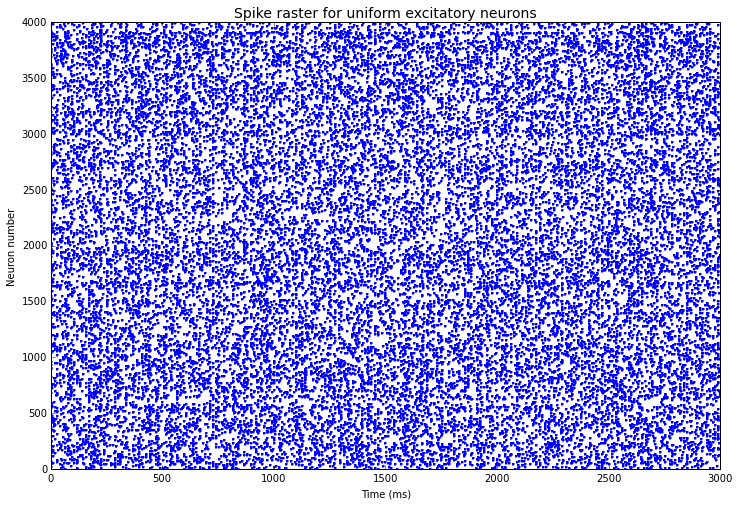

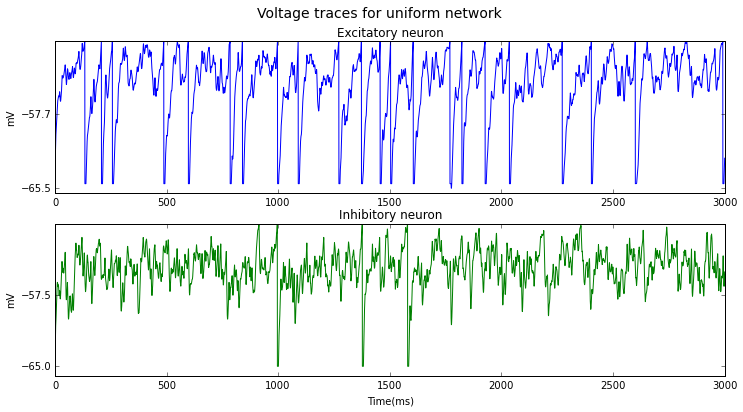

In [10]:
# Plot spike raster plots, blue exc neurons, red inh neurons
fig1 = plt.figure()
raster_plot(spike_mon_e)
plt.title('Spike raster for uniform excitatory neurons', fontsize = 14)
#fig1.savefig('raster_plot_uniform.png')

# Show the plots
fig2 = plt.figure(figsize=(12,6))
plt.subplot(211)
y = state_mon_v_e.values[3,:]*1000.0 # Converting to mV
x = state_mon_v_e.times*1000
plt.plot(x, y, 'b')
plt.yticks([min(y), (max(y)-min(y))/2.0+min(y)])
plt.yticks(np.round([min(y), (max(y)-min(y))/2.0+min(y)],1))
plt.ylabel("mV")
plt.title("Excitatory neuron")
plt.subplot(212)
y = state_mon_v_i.values[2,:]*1000.0 # Converting to mV
x = state_mon_v_i.times * 1000
plt.plot(x, y, 'g')
plt.yticks(np.round([min(y), (max(y)-min(y))/2.0+min(y)],1))
plt.ylabel("mV")
plt.xlabel("Time(ms)")
plt.title("Inhibitory neuron")
plt.suptitle("Voltage traces for uniform network", fontsize=14)
#fig2.savefig("voltage_traces_uniform.png")

In [10]:
np.round([min(y), (max(y)-min(y))/2.0+min(y)],1)

array([-65. , -57.5])